# **2024-02-11_Dushyant_Session1**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time

### Dataset
We used a realestate dataset from Kaggle to produce this reduced dataset. This dataset contains the _sale price_ and _above ground square feet_ of many houses. We can use this data for our linear regression.

We use Pandas to read the data file which is stored as Comma Separated Values (CSV). and print the column labels. CSV files are similar to excel sheets.

In [2]:
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)

Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')


Now pandas provides some helpful tools for us to inspect our data. It provides a `plot()` function that, behind the scenes, is calling into the _Matplotlib_ library and calling the function [matplotlib.pyplot.plot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). In this case, we simply tell it the names of the columns we want as our _x_ and _y_ values and the `style` (`'.'` tells `matplotlib` to use a small dot to represent each data point).

<AxesSubplot: xlabel='GrLivArea'>

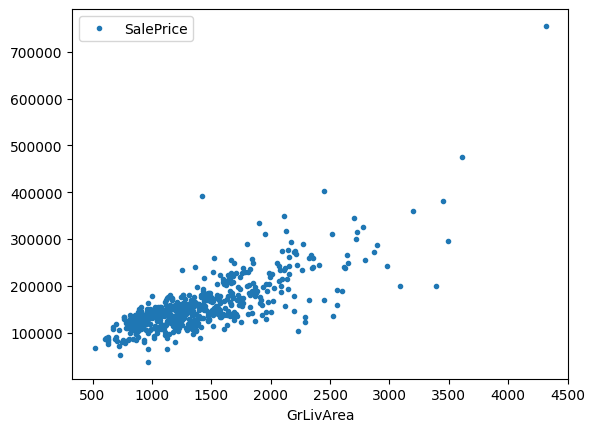

In [3]:
data.plot(x='GrLivArea',y='SalePrice',style='.')

### Theory of linear regression

If you have data, $(x,y)$, that you think can be fit by a line, $y = m x + b$, then there are [simple equations](https://en.wikipedia.org/wiki/Simple_linear_regression) one can use to calculate the slope ($m$) and intercept ($b$).

They are:

$$m = { n (\Sigma xy) - (\Sigma x) (\Sigma y) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

$$b = { (\Sigma y) (\Sigma x^2) - (\Sigma x) (\Sigma xy) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

We'll break this calculation into a few steps to help make it easier.

First lets define $x$ and $y$. $x$ will be our _above ground square footage_ and $y$ will be _sale price_. In our equations we have a few different values we need, such as $n$ which is just the number of points we have:

In [4]:
n = len(data)

Then we need our $x$ and $y$ by selecting only the column we care about for each one. Note about data formats: `data` is a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) object which has rows and columns; `data['GrLivArea']` is a Pandas [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object which only has rows; then we also convert from _Pandas_ data formats (in this case a _Series_) to _Numpy_ data formats using the `to_numpy()` function which is part of the Pandas _Series_ object.

In [5]:
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()

Now we will calculate $\Sigma xy$, $\Sigma x$, $\Sigma y$, and $\Sigma x^2$:

In [6]:
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)

The denominator in the equation for $m$ and $b$ are the same so we can calculate that once:

In [7]:
denominator = n * sum_x2 - sum_x * sum_x

Then we can calculate our fit values:

In [8]:
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# saving these for later comparison
m_calc = m
b_calc = b

y = 87.688145 * x + 34754.077892


Now we can plot the fit results with our data to see how we did.

First we define a plotting function because we're going to do this often and we want to reuse our code:

In [9]:
def plot_data(x,y,m,b,plt = plt):
   # plot our data points with 'bo' = blue circles
   plt.plot(x,y,'bo')
   # create the line based on our linear fit
   # first we need to make x points
   # the 'arange' function generates points between two limits (min,max)
   linear_x = np.arange(x.min(),x.max())
   # now we use our fit parameters to calculate the y points based on our x points
   linear_y = linear_x * m + b
   # plot the linear points using 'r-' = red line
   plt.plot(linear_x,linear_y,'r-',label='fit')

Now can use this function to plot our results:

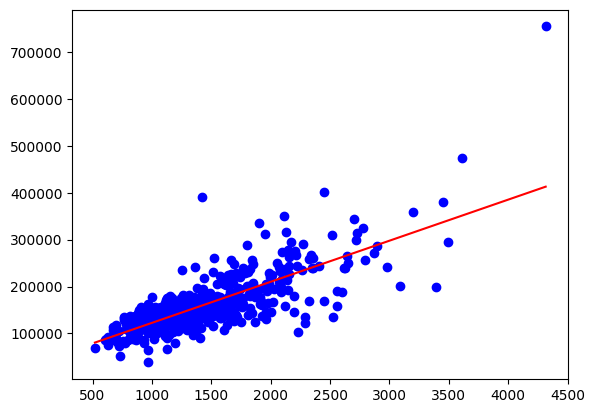

In [10]:
plot_data(x,y,m,b)

### Training through Stochastic Gradient Descent (SGD)

This is adopted from Bethany Lusch, ALCF.

SGD is a common method in AI for training deep neural networks on large datasets. It is an iterative method for optimizing a loss function that we get to define. We will use this simple linear regression to demonstrate how it works.

#### The model

In AI, neural networks are often referred to as a _model_ because, once fully trained, they should model (AKA predict) the behavior of our system. In our example, the system is how house prices vary based on house size. We know our system is roughly driven by a linear function:

$$ \hat{y_i}(x_i) = m * x_i + b $$

We just need to figure out $m$ and $b$. Let's create a function that calculates our model given $x$, $m$, and $b$.


In [11]:
def model(x,m,b):
   return m * x + b


#### The Loss Function

A _loss function_, or _objective function_, is something we define and is based on what we want to achieve. In the method of SGD, it is our goal to minimize (or make close to zero) the values calculated from the _loss function_. In our example, we ideally want the prediction of our _model_ to be equal to the actual data, though we will settle for "as close as possible".

So we will select our _loss function_ to be the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) function:

$$ L(y_i,\hat{y_i}) = (y_i - \hat{y_i}(x_i))^2 $$

where $y_i$ is our $i^{th}$ entry in the `data['SalePrice']` vector and $\hat{y_i}$ is the prediction based on evaluting $m * x_i + b$.

This function looks like the figure below when we plot it with $x=y_i - \hat{y_i}(x_i)$ and we we want to be down near $y_i - \hat{y_i}(x_i) = 0$ which indicates that our $y_i$ is as close as possible to $\hat{y_i}$.

![loss_func](https://github.com/DArora-Monk-777X/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/loss_func.png?raw=1)


Here we crate a function that calculates this for us.

In [12]:
def loss(x,y,m,b):
   y_predicted = model(x,m,b)
   return np.power( y - y_predicted, 2 )

#### Minimizing the Loss Function

We want to use the loss function in order to guide how to update $m$ and $b$ to better model our system. In calculus we learn to minimize a function with respect to a variable you calculate the _partial derivative_ with respect to the variable you want to vary.

$$ { \partial L \over \partial m } = 0 $$

The location of the solution to this is the minimum as shown in the figure above. We can write down the partial derivative of the loss function as:

$$ { \partial L \over \partial m } = -2 x_i (y_i - \hat{y_i}(x_i)) $$
$$ { \partial L \over \partial b } = -2 (y_i - \hat{y_i}(x_i)) $$

We can use this to calculate an adjustment to $m$ and $b$ that will reduce the loss function, effectively improving our fitting parameters. This is done using this equation:

$$ m' = m - \eta { \partial L \over \partial m }$$
$$ b' = b - \eta { \partial L \over \partial b }$$

Here our original $m$ and $b$ are adjusted by the partial derivative multiplied by some small factor, $\eta$, called the _learning rate_. This learning rate is very important in our process and must be tuned for every problem.

In our example, the selection of the learning rate essentially defines how close we can get to the minimum, AKA the best fit solution. This figure shows what happens when we pick a large learning rate. We first select a starting point in our loss function (typically randomly), then every update from $m$/$b$ to $m'$/$b'$ results in a shift to somewhere else on our loss function (following the red arrows). In this example, our learning rate ($\eta$) has been selected too large such that we bounce back and forth around the minimum, never reaching it.

![largeLR](https://github.com/DArora-Monk-777X/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/parabola_largeLR.png?raw=1)

If we select a smaller learning we can see better behavior in the next figure.

![smallLR](https://github.com/DArora-Monk-777X/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/parabola_smallLR.png?raw=1)

Though, keep in mind, too small a learning rate results is so little progress toward the minimum that you may never reach it!

A pit fall of SGD that one must be aware of is when your loss function is complex, with many minima. The next figure shows such a case, in which we select a small learning rate and our starting point happens to be near a local minimum that is not the lowest minimum. As shown, we do reach a minimum, but it isn't the lowest minimum in our loss function. It could be that we randomly select a starting point near the minimum we care about, but we should build methods that are more robust against randomly getting the right answer.

![local_min_smallLR](https://github.com/DArora-Monk-777X/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/local_min_smallLR.png?raw=1)

Then, if we increase our learning rate too much, we bounce around again.

![local_min_largeLR](https://github.com/DArora-Monk-777X/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/local_min_largeLR.png?raw=1)

What we want to do in this situation is start with a large learning rate and slowly reduce its size as we progress. That is shown in this next figure.

![local_min_variableLR](https://github.com/DArora-Monk-777X/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/local_min_variableLR.png?raw=1)

As you can see, this process is not perfect and could still land in a local minimum, but it is important to be aware of these behaviors as you utilize SGD in machine learning.

So let's continue, we'll build functions we can use to update our fit parameters, $m$ and $b$.

In [13]:
def updated_m(x,y,m,b,learning_rate):
   dL_dm = - 2 * x * (y - model(x,m,b))
   dL_dm = np.mean(dL_dm)
   return m - learning_rate * dL_dm

def updated_b(x,y,m,b,learning_rate):
   dL_db = - 2 * (y - model(x,m,b))
   dL_db = np.mean(dL_db)
   return b - learning_rate * dL_db

# Putting it together

We can now randomly select our initial slope and intercept:

In [14]:
m = 5.
b = 1000.
print('y_i = %.2f * x + %.2f' % (m,b))

y_i = 5.00 * x + 1000.00


Then we can calculate our Loss function:

In [15]:
l = loss(x,y,m,b)
print('first 10 loss values: ',l[:10])

first 10 loss values:  [3.03421561e+10 3.55511025e+10 1.24579082e+10 1.91656336e+10
 1.60604929e+10 2.04432804e+10 1.72410030e+10 1.76517796e+10
 1.52769600e+10 2.18152900e+10]


y_i = 5.47 * x + 1000.00     previously calculated: y_i = 87.69 * x + 34754.08


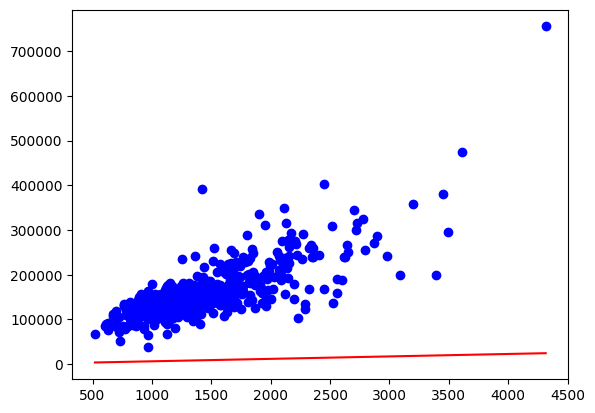

In [16]:
learning_rate = 1e-9
m = updated_m(x,y,m,b,learning_rate)
b = updated_b(x,y,m,b,learning_rate)
print('y_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f' % (m,b,m_calc,b_calc))
plot_data(x,y,m,b)

[029]  dy_i = 88.89 * x + 32912.24     previously calculated: y_i = 87.69 * x + 34754.08    loss: 1478200827.641291


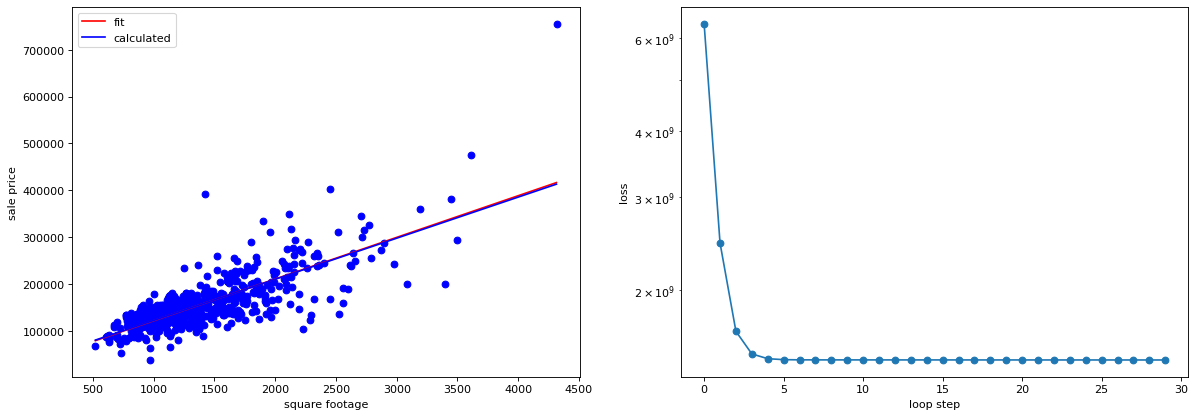

In [17]:
# set our initial slope and intercept
m = 5.
b = 1000.
# batch_size = 60
# set a learning rate for each parameter
learning_rate_m = 1e-7
learning_rate_b = 1e-1
# use these to plot our progress over time
loss_history = []

# we run our loop N times
loop_N = 30
for i in range(loop_N):

   # convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
   data_x = data['GrLivArea'].to_numpy()
   data_y = data['SalePrice'].to_numpy()

   # update our slope and intercept based on the current values
   m = updated_m(data_x,data_y,m,b,learning_rate_m)
   b = updated_b(data_x,data_y,m,b,learning_rate_b)

   # calculate the loss value
   loss_value = np.mean(loss(data_x,data_y,m,b))

   # keep a history of our loss values
   loss_history.append(loss_value)

   # print our progress
   print('[%03d]  dy_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f    loss: %f' % (i,m,b,m_calc,b_calc,loss_value))

   # close/delete previous plots
   plt.close('all')

   # create a 1 by 2 plot grid
   fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)
   # lot our usual output
   plot_data(data_x,data_y,m,b,ax[0])

   # here we also plot the calculated linear fit for comparison
   line_x = np.arange(data_x.min(),data_x.max())
   line_y = line_x * m_calc + b_calc
   ax[0].plot(line_x,line_y,'b-',label='calculated')
   # add a legend to the plot and x/y labels
   ax[0].legend()
   ax[0].set_xlabel('square footage')
   ax[0].set_ylabel('sale price')

   # plot the loss
   loss_x = np.arange(0,len(loss_history))
   loss_y = np.asarray(loss_history)
   ax[1].plot(loss_x,loss_y, 'o-')
   ax[1].set_yscale('log')
   ax[1].set_xlabel('loop step')
   ax[1].set_ylabel('loss')
   plt.show()
   # gives us time to see the plot
   time.sleep(2.5)
   # clears the plot when the next plot is ready to show.
   ipydis.clear_output(wait=True)



#### In Class Exercises
1. In AI, datasets are often very large and cannot be processed all at once as is done in the loop above. The data is instead randomly sampled in smaller _batches_ where each _batch_ contains `batch_size` inputs. How can you change the loop above to sample the dataset in smaller batches? Hint: Our `data` variable is a Pandas `DataFrame` object, search for "how to sample a DataFrame".
2. As described above, learning rates that grow smaller over time can help find and get closer to global minima. In the loop above, our `learning_rate_m` and `learning_rate_b` are constant through the process of minimizing our parameters. How could you change the loop to reduce the learning rates over loop iterations?


[024]  dy_i = 84.40 * x + 34510.05     previously calculated: y_i = 87.69 * x + 34754.08    loss: 2339713265.365668


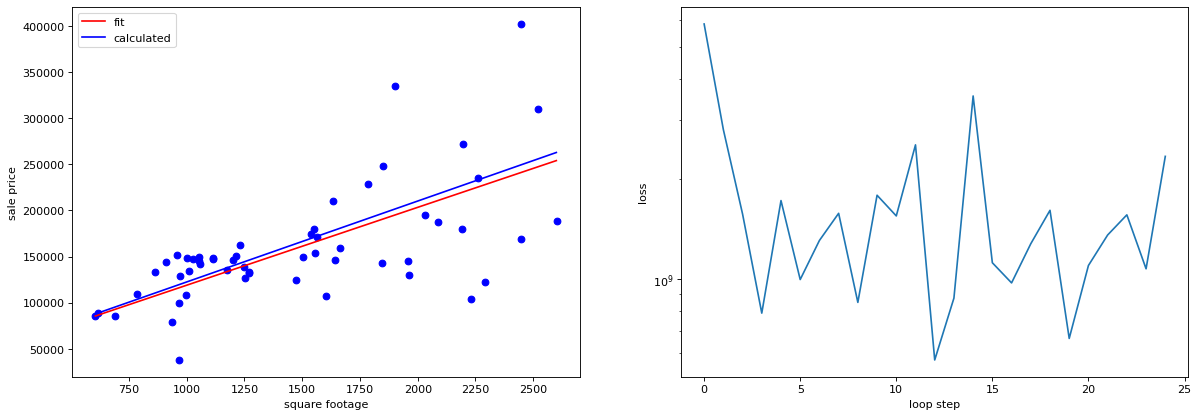

In [18]:
# set our initial slope and intercept
m = 5.
b = 1000.
# batch_size = 60
# set a learning rate for each parameter
learning_rate_m = 1e-7
learning_rate_b = 1e-1
# use these to plot our progress over time
loss_history = []

batch_size = 55
# we run our loop N times


loop_N =25
for i in range(loop_N):

   # convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
   data_batch = data.sample(batch_size)
   data_x = data_batch['GrLivArea'].to_numpy()
   data_y = data_batch['SalePrice'].to_numpy()

   # update our slope and intercept based on the current values
   m = updated_m(data_x,data_y,m,b,learning_rate_m)
   b = updated_b(data_x,data_y,m,b,learning_rate_b)

   # calculate the loss value
   loss_value = np.mean(loss(data_x,data_y,m,b))

   # keep a history of our loss values
   loss_history.append(loss_value)

   # print our progress
   print('[%03d]  dy_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f    loss: %f' % (i,m,b,m_calc,b_calc,loss_value))

   # close/delete previous plots
   plt.close('all')

   # create a 1 by 2 plot grid
   fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)
   # lot our usual output
   plot_data(data_x,data_y,m,b,ax[0])

   # here we also plot the calculated linear fit for comparison
   line_x = np.arange(data_x.min(),data_x.max())
   line_y = line_x * m_calc + b_calc
   ax[0].plot(line_x,line_y,'b-',label='calculated')
   # add a legend to the plot and x/y labels
   ax[0].legend()
   ax[0].set_xlabel('square footage')
   ax[0].set_ylabel('sale price')

   # plot the loss
   loss_x = np.arange(0,len(loss_history))
   loss_y = np.asarray(loss_history)
   ax[1].plot(loss_x,loss_y)
   ax[1].set_yscale('log')
   ax[1].set_xlabel('loop step')
   ax[1].set_ylabel('loss')
   plt.show()
   # gives us time to see the plot
   time.sleep(2.5)
   # clears the plot when the next plot is ready to show.
   ipydis.clear_output(wait=True)



# My Session1 Homework

**Part 1: Mini batch training**

Instead of using the entire dataset like
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()
Use
data_batch = data.sample(batch_size)
data_x = data_batch['GrLivArea'].to_numpy()
data_y = data_batch['SalePrice'].to_numpy()
You also have to adjust the loop_N accordingly to make sure that it loop over the entire datasets the same number of times.
loop_N = 30*len(data)//batch_size

Batch Size: 32
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 88.79636130072356 * x + 30377.77345194042
Mean Loss: 1040274556.8276486


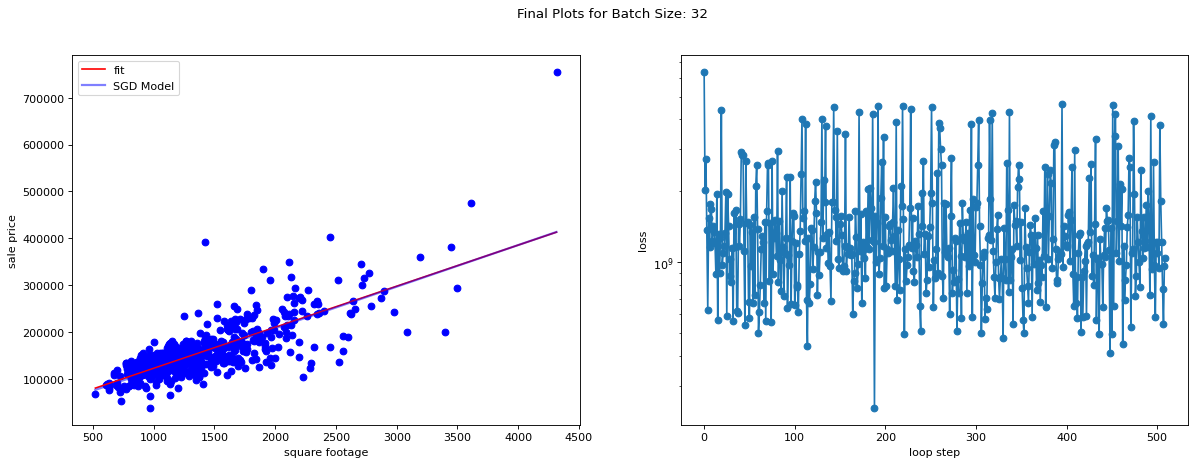

Batch Size: 64
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 90.70025848020342 * x + 29795.08449172878
Mean Loss: 1352858769.5320475


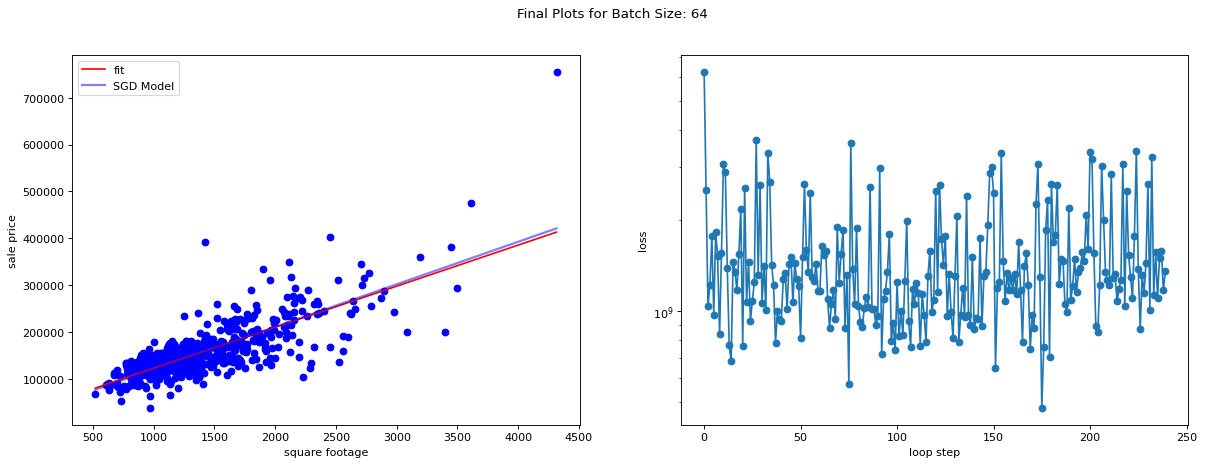

Batch Size: 128
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 86.29883703253226 * x + 35743.968393789444
Mean Loss: 1001981846.4181173


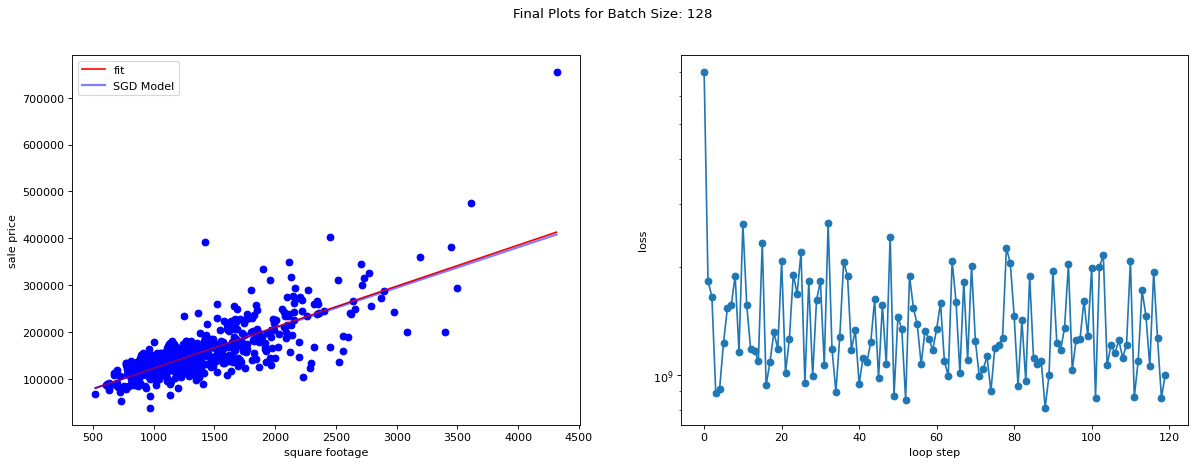

Batch Size: 256
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 90.9944601644358 * x + 32423.36063540187
Mean Loss: 1749710500.8941455


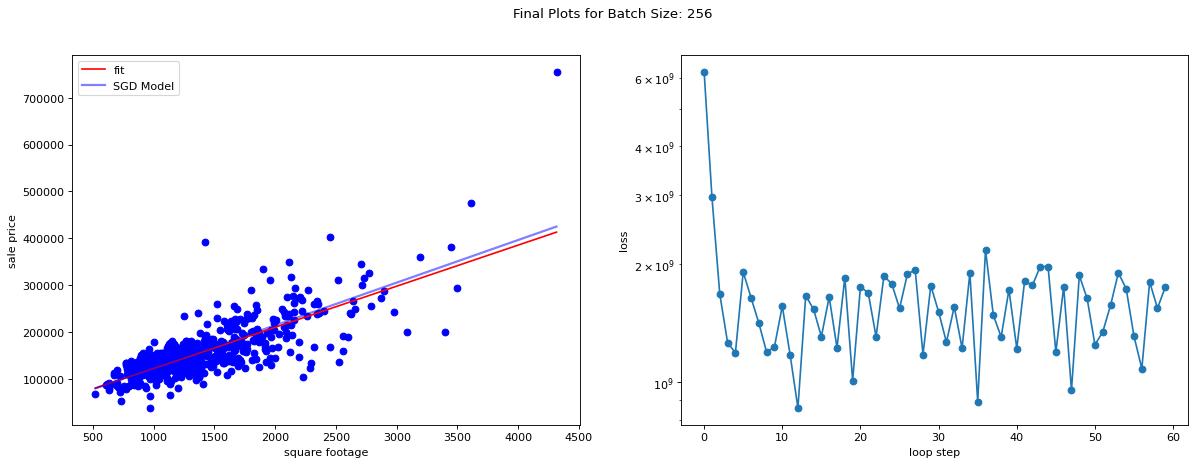

Batch Size: 512
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 88.90910878518089 * x + 32809.18879574055
Mean Loss: 1482891526.933985


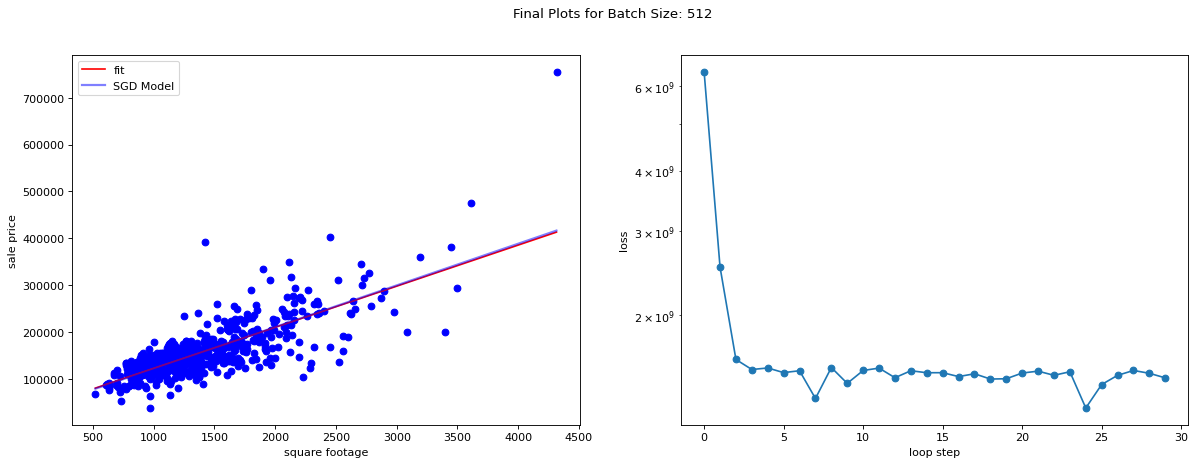

In [19]:
# set the array of batch sizes 
batch_sizes = [32, 64, 128, 256, 512]

# set the number of epochs
epochs = 30

# Now performing SGD for each of the batch size
for batch_size in batch_sizes:
    # set the initial values of m and b inside of this loop so that
    # they are reset to original guess values for each batch size
    m = 5.
    b = 1000.
    
    # Print the batch size
    print(100*'=')
    print(f"Batch Size: {batch_size}")
    
    # obtain the number of iterations
    num_iterations = len(data)//batch_size
    
    
    # set a learning rate for each parameter
    learning_rate_m = 1e-7
    learning_rate_b = 1e-1
    
    
    # use these to plot our progress over time
    loss_history = []
    
    # the number of times entire dataset is trained is the epochs
    loop_N = epochs
    
    
    for i in range(loop_N):
        
        for j in range(num_iterations):
    
            # Sample a batch of data according to batch size
            data_batch = data.sample(batch_size)
            
             # convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
            data_x = data_batch['GrLivArea'].to_numpy()
            data_y = data_batch['SalePrice'].to_numpy()
    
            # update our slope and intercept based on the current values
            m = updated_m(data_x,data_y,m,b,learning_rate_m)
            b = updated_b(data_x,data_y,m,b,learning_rate_b)

            # calculate the loss value
            loss_value = np.mean(loss(data_x,data_y,m,b))

            # keep a history of our loss values
            loss_history.append(loss_value)

            # close/delete previous plots
            # plt.close('all')
            
            if (i == loop_N-1  and j == num_iterations-1):
                print(f"Analytic Model: y_i = {m_calc} * x + {b_calc}")
                print(f"SGD Model: y_i = {m} * x + {b}")
                print(f"Mean Loss: {loss_value}")
                # print(100*'*')
                # create a 1 by 2 plot grid
                fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)
                # lot our usual output
                plot_data(data['GrLivArea'],data['SalePrice'], m_calc, b_calc, ax[0])

                # here we also plot the SGD linear fit for comparison
                line_x = np.arange(data['GrLivArea'].min(), data['GrLivArea'].max())
                line_y = line_x * m + b
                ax[0].plot(line_x,line_y,label='SGD Model', linewidth=2, alpha=0.5, color='b')
                # add a legend to the plot and x/y labels
                ax[0].legend()
                ax[0].set_xlabel('square footage')
                ax[0].set_ylabel('sale price')

                # plot the loss 
                loss_x = np.arange(0,len(loss_history))
                loss_y = np.asarray(loss_history)
                ax[1].plot(loss_x,loss_y, 'o-')
                ax[1].set_yscale('log')
                ax[1].set_xlabel('loop step')
                ax[1].set_ylabel('loss')
                fig.suptitle(f"Final Plots for Batch Size: {batch_size}")
                plt.show()
                # gives us time to see the plot
                time.sleep(10.5)
                # clears the plot when the next plot is ready to show.
                # ipydis.clear_output(wait=True)






# My Session1 Bonus Homework

##
Learning rate issue (Bonus)
As described above, if the learning rate is too large, it will affect the convergence. Do your training with (batch_size = 64, learning_rate_m = 1e-7, learning_rate_b = 1e-1). Then linearly increase the batch size and learning rate until you see the training does not converge.

(64, 1e-7, 1e-1)*1

(64, 1e-7, 1e-1)*2

(64, 1e-7, 1e-1)*4

(64, 1e-7, 1e-1)*8
...

Batch Size: 64
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 86.51192026087081 * x + 34500.75183361641
Mean Loss: 1255749521.767847
Learning Rate For m: 1e-07
Learning Rate for b: 0.1


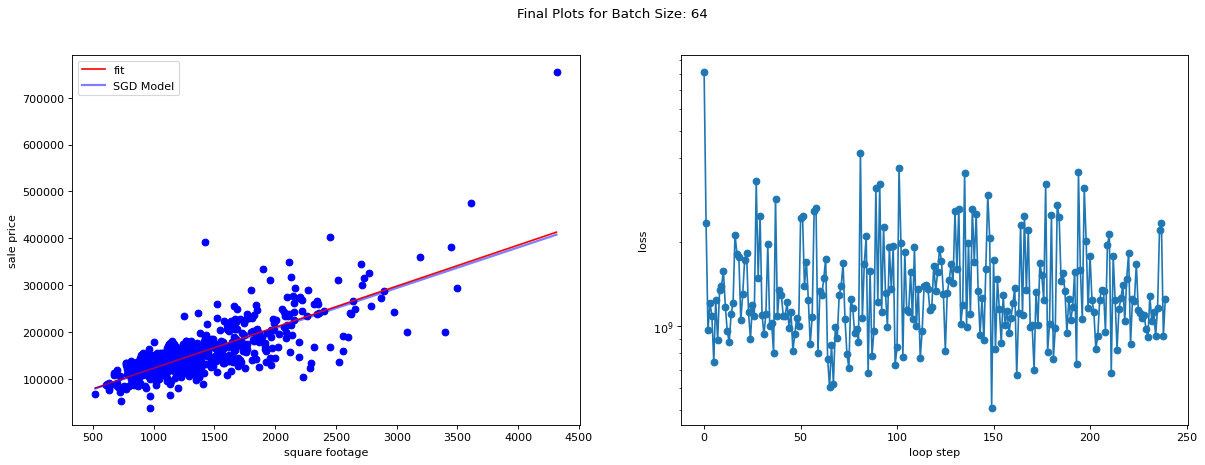

Batch Size: 128
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 83.71494495759111 * x + 38043.107598714385
Mean Loss: 1080696003.855189
Learning Rate For m: 2e-07
Learning Rate for b: 0.2


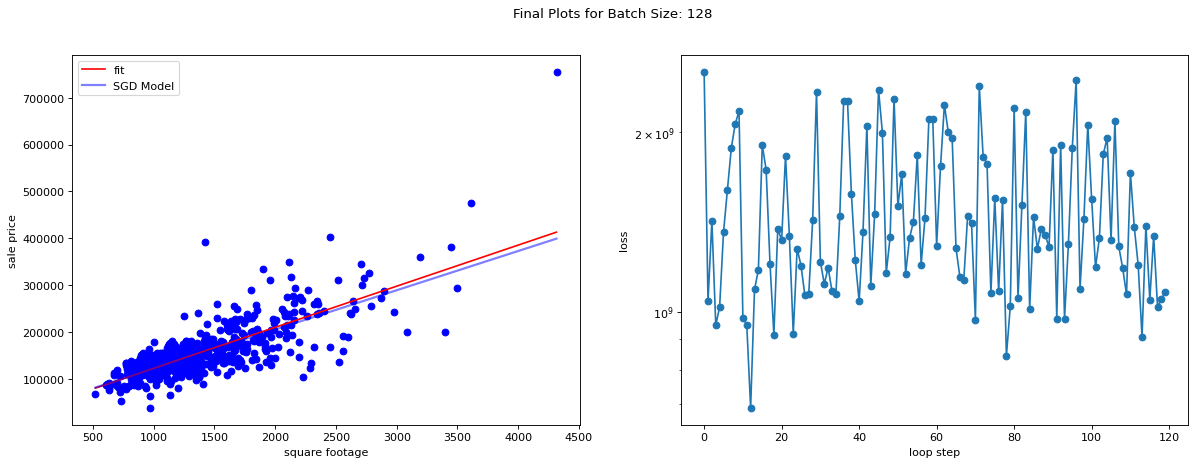

Batch Size: 256
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 86.21495461773263 * x + 37941.122807217325
Mean Loss: 1678940816.0339327
Learning Rate For m: 4e-07
Learning Rate for b: 0.4


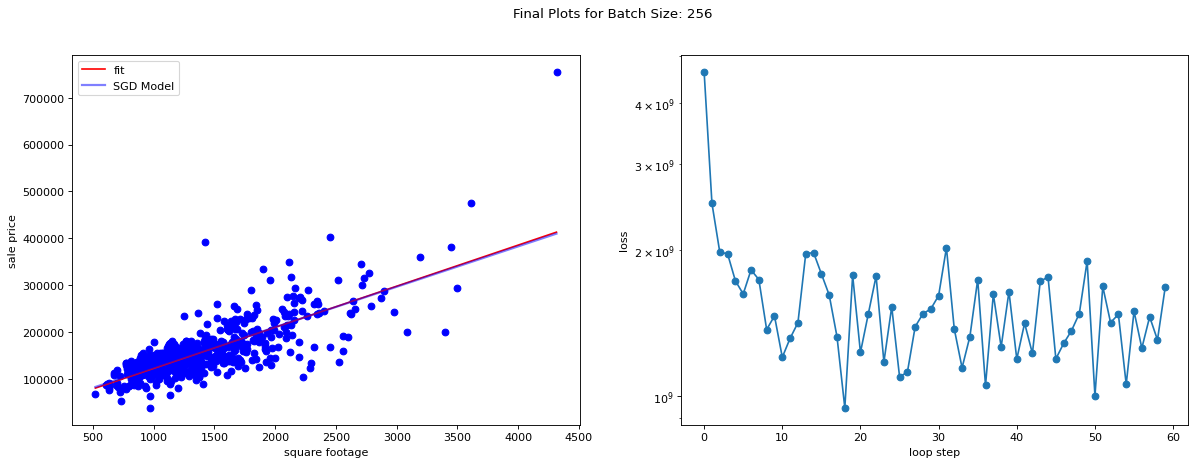

Batch Size: 512
Analytic Model: y_i = 87.6881454948481 * x + 34754.077891844456
SGD Model: y_i = 154289.3146311247 * x + -107121518.91550046
Mean Loss: 1.784859413252214e+16
Learning Rate For m: 8e-07
Learning Rate for b: 0.8


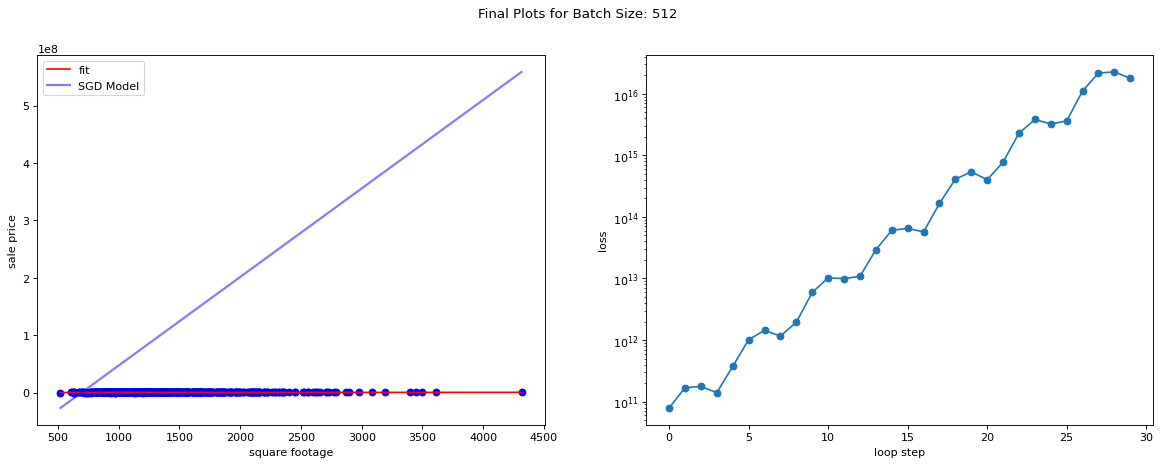

In [ ]:
# set the array of batch sizes
batch_sizes = 64 * np.array([2**i for i in range(4)])

# set the number of epochs
epochs = 30

# Now use SGD modelling for each of the batch size
for num, batch_size in enumerate(batch_sizes):
    # set the initial values of m and b inside of this loop so that
    # they are reset to original guess values for each batch size
    m = 5.
    b = 1000.
    # Print the batch size
    print(100*'=')
    print(f"Batch Size: {batch_size}")
    # obtain the number of iterations
    num_iterations = len(data)//batch_size
    # set a learning rate for each parameter
    learning_rate_m = 1e-7 * (2 ** num)
    learning_rate_b = 1e-1 * (2 ** num)
    # use these to plot our progress over time
    loss_history = []
    # the number of times entire dataset is trained is the epochs
    loop_N = epochs
    for i in range(loop_N):
        for j in range(num_iterations):
            # Sample a batch of data according to batch size
            data_batch = data.sample(batch_size)
            # convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
            data_x = data_batch['GrLivArea'].to_numpy()
            data_y = data_batch['SalePrice'].to_numpy()
            # update our slope and intercept based on the current values
            m = updated_m(data_x,data_y,m,b,learning_rate_m)
            b = updated_b(data_x,data_y,m,b,learning_rate_b)
            # calculate the loss value
            loss_value = np.mean(loss(data_x,data_y,m,b))
            # keep a history of our loss values
            loss_history.append(loss_value)
            # close/delete previous plots
            # plt.close('all')
            if (i == loop_N-1  and j == num_iterations-1):
                print(f"Analytic Model: y_i = {m_calc} * x + {b_calc}")
                print(f"SGD Model: y_i = {m} * x + {b}")
                print(f"Mean Loss: {loss_value}")
                print(f"Learning Rate For m: {learning_rate_m}")
                print(f"Learning Rate for b: {learning_rate_b}")
                # create a 1 by 2 plot grid
                fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)
                # plot our usual output
                plot_data(data['GrLivArea'], data['SalePrice'], m_calc, b_calc, ax[0])
                # here we also plot the calculated linear fit for comparison
                line_x = np.arange(data['GrLivArea'].min(), data['GrLivArea'].max())
                line_y = line_x * m + b
                ax[0].plot(line_x,line_y,label='SGD Model', linewidth=2, alpha=0.5, color='b')
                # add a legend to the plot and x/y labels
                ax[0].legend()
                ax[0].set_xlabel('square footage')
                ax[0].set_ylabel('sale price')
                # plot the loss
                loss_x = np.arange(0,len(loss_history))
                loss_y = np.asarray(loss_history)
                ax[1].plot(loss_x,loss_y, 'o-')
                ax[1].set_yscale('log')
                ax[1].set_xlabel('loop step')
                ax[1].set_ylabel('loss')
                fig.suptitle(f"Final Plots for Batch Size: {batch_size}")
                plt.show()
                # gives us time to see the plot
                time.sleep(25.5)
                # clears the plot when the next plot is ready to show.
                # ipydis.clear_output(wait=True)

# It is evident from the above graphs that we will not get convergence with large batch sizes and large learning rates because we will miss local minima/maxima areas of the function